In [1]:
import sys

sys.path.append('/glade/work/chuyan/Research/Cloud_CCFs_RMs_Tan_et_al_2023_JGR-A__')

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# import PyNIO as Nio #deprecated
import pandas as pd
import glob
from scipy.stats import *
from copy import deepcopy
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm

from area_mean import *
from scipy.optimize import curve_fit
# import seaborn as sns
from copy import deepcopy
from useful_func_cy import *

### Fig 9:
Probability density function of 40^{o}S - 85^{o}S SW_{FB} with constraint range:

In [3]:
# model list

exp = 'piControl'
    
# CMIP6: 31 (30: BCCCSMCM2MR)
AWICM11MR = {'modn': 'AWI-CM-1-1-MR', 'consort': 'AWI', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
BCCESM1 = {'modn': 'BCC-ESM1', 'consort': 'BCC', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CAMSCSM1 = {'modn': 'CAMS-CSM1-0', 'consort': 'CAMS', 'cmip': 'cmip6',
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CMCCCM2SR5 = {'modn': 'CMCC-CM2-SR5', 'consort': 'CMCC', 'cmip': 'cmip6', 
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2 = {'modn': 'CESM2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2FV2 = {'modn': 'CESM2-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCM = {'modn': 'CESM2-WACCM', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CESM2WACCMFV2 = {'modn': 'CESM2-WACCM-FV2', 'consort': 'NCAR', 'cmip': 'cmip6',
             'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
CNRMCM61 = {'modn': 'CNRM-CM6-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMCM61HR = {'modn': 'CNRM-CM6-1-HR', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CNRMESM21 = {'modn': 'CNRM-ESM2-1', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gr', "typevar": 'Amon'}
CanESM5 = {'modn': 'CanESM5', 'consort': 'CCCma', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
E3SM10 = {'modn': 'E3SM-1-0', 'consort': 'E3SM-Project', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3 = {'modn': 'EC-Earth3', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
ECEarth3Veg = {'modn': 'EC-Earth3-Veg', 'consort': 'EC-Earth-Consortium', 'cmip': 'cmip6',
       'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
FGOALSg3 = {'modn': 'FGOALS-g3', 'consort': 'CAS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21G = {'modn': 'GISS-E2-1-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE21H = {'modn': 'GISS-E2-1-H', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GISSE22G = {'modn': 'GISS-E2-2-G', 'consort': 'NASA-GISS', 'cmip': 'cmip6',
               'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
GFDLCM4 = {'modn': 'GFDL-CM4', 'consort': 'NOAA-GFDL', 'cmip': 'cmip6',
           'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
INM_CM48 = {'modn': 'INM-CM4-8', 'consort': 'INM', 'cmip': 'cmip6', 
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr1', "typevar": 'Amon'}
IPSLCM6ALR = {'modn': 'IPSL-CM6A-LR', 'consort': 'IPSL', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gr', "typevar": 'Amon'}
MIROCES2L = {'modn': 'MIROC-ES2L', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f2', 'gg': 'gn', "typevar": 'Amon'}
MIROC6 = {'modn': 'MIROC6', 'consort': 'MIROC', 'cmip': 'cmip6',
              'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MPIESM12LR = {'modn': 'MPI-ESM1-2-LR', 'consort': 'MPI-M', 'cmip': 'cmip6',
                  'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
MRIESM20 = {'modn': 'MRI-ESM2-0', 'consort': 'MRI', 'cmip': 'cmip6',
                'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NESM3 = {'modn': 'NESM3', 'consort': 'NUIST', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
NorESM2MM = {'modn': 'NorESM2-MM', 'consort': 'NCC', 'cmip': 'cmip6',
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
SAM0 = {'modn': 'SAM0-UNICON', 'consort': 'SNU', 'cmip': 'cmip6', 
            'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}
TaiESM1 = {'modn': 'TaiESM1', 'consort': 'AS-RCEC', 'cmip': 'cmip6', 
                 'exper': exp, 'ensmem': 'r1i1p1f1', 'gg': 'gn', "typevar": 'Amon'}

# CMIP5: 20 (18, ACCESS10, ACCESS13)
ACCESS10 = {'modn': 'ACCESS1-0', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
ACCESS13 = {'modn': 'ACCESS1-3', 'consort': 'CSIRO-BOM', 'cmip': 'cmip5',   # 2-d (145) and 3-d (146) variables have different lat shape
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
BNUESM = {'modn': 'BNU-ESM', 'consort': 'BNU', 'cmip': 'cmip5',
          'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CCSM4 = {'modn': 'CCSM4', 'consort': 'NCAR', 'cmip': 'cmip5',
             'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CNRMCM5 = {'modn': 'CNRM-CM5', 'consort': 'CNRM-CERFACS', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CSIRO_Mk360 = {'modn': 'CSIRO-Mk3-6-0', 'consort': 'CSIRO-QCCCE', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
CanESM2 = {'modn': 'CanESM2', 'consort': 'CCCma', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSg2 = {'modn': 'FGOALS-g2', 'consort': 'LASG-CESS', 'cmip': 'cmip5',   # missing 'prw' in piControl
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
FGOALSs2 = {'modn': 'FGOALS-s2', 'consort': 'LASG-IAP', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLCM3 = {'modn': 'GFDL-CM3', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2H = {'modn': 'GISS-E2-H', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GISSE2R = {'modn': 'GISS-E2-R', 'consort': 'NASA-GISS', 'cmip': 'cmip5',
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
IPSLCM5ALR = {'modn': 'IPSL-CM5A-LR', 'consort': 'IPSL', 'cmip': 'cmip5',
               'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROC5 = {'modn': 'MIROC5', 'consort': 'MIROC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMMR = {'modn': 'MPI-ESM-MR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
NorESM1M = {'modn': 'NorESM1-M', 'consort': 'NCC', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MIROCESM = {'modn': 'MIROC-ESM', 'consort': 'MIROC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MRICGCM3 = {'modn': 'MRI-CGCM3', 'consort': 'MRI', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
MPIESMLR = {'modn': 'MPI-ESM-LR', 'consort': 'MPI-M', 'cmip': 'cmip5',
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
bcccsm11 = {'modn': 'bcc-csm1-1', 'consort': 'BCC', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2G = {'modn': 'GFDL-ESM2G', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
            'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}
GFDLESM2M = {'modn': 'GFDL-ESM2M', 'consort': 'NOAA-GFDL', 'cmip': 'cmip5', 
           'exper': exp, 'ensmem': 'r1i1p1', "typevar": 'Amon'}

# cmip5 + cmip6 (50):

deck2 = [BCCESM1, CanESM5, CESM2, CESM2FV2, CESM2WACCM, CNRMESM21, GISSE21G, GISSE21H, IPSLCM6ALR, MRIESM20, MIROC6, SAM0, E3SM10, FGOALSg3, GFDLCM4, CAMSCSM1, INM_CM48, MPIESM12LR, AWICM11MR, CMCCCM2SR5, CESM2WACCMFV2, CNRMCM61, CNRMCM61HR, ECEarth3, ECEarth3Veg, GISSE22G, MIROCES2L, NESM3, NorESM2MM, TaiESM1, BNUESM, CCSM4, CNRMCM5, CSIRO_Mk360, CanESM2, FGOALSg2, FGOALSs2, GFDLCM3, GISSE2H, GISSE2R, IPSLCM5ALR, MIROC5, MPIESMMR, NorESM1M, MIROCESM, MRICGCM3, MPIESMLR, bcccsm11, GFDLESM2G, GFDLESM2M]  # current # 30 + 20 = 50
deck_nas2 = ['BCCESM1', 'CanESM5', 'CESM2', 'CESM2FV2', 'CESM2WACCM', 'CNRMESM21', 'GISSE21G', 'GISSE21H', 'IPSLCM6ALR', 'MRIESM20', 'MIROC6', 'SAM0', 'E3SM10', 'FGOALSg3', 'GFDLCM4', 'CAMSCSM1', 'INM_CM48', 'MPIESM12LR', 'AWICM11MR', 'CMCCCM2SR5', 'CESM2WACCMFV2', 'CNRMCM61', 'CNRMCM61HR', 'ECEarth3', 'ECEarth3Veg', 'GISSE22G', 'MIROCES2L', 'NESM3', 'NorESM2MM', 'TaiESM1', 'BNUESM', 'CCSM4', 'CNRMCM5', 'CSIRO_Mk360', 'CanESM2', 'FGOALSg2', 'FGOALSs2', 'GFDLCM3', 'GISSE2H', 'GISSE2R', 'IPSLCM5ALR', 'MIROC5', 'MPIESMMR', 'NorESM1M', 'MIROCESM', 'MRICGCM3', 'MPIESMLR', 'bcccsm11', 'GFDLESM2G', 'GFDLESM2M']  # current # 30 + 20 = 50

deck3 = [CanESM5, E3SM10, CESM2FV2, CESM2, CNRMCM61, CESM2WACCMFV2, CNRMESM21, NESM3, IPSLCM6ALR, CESM2WACCM, MIROCESM, TaiESM1, ECEarth3Veg, CNRMCM61HR, ECEarth3, 
         FGOALSs2, IPSLCM5ALR, CSIRO_Mk360, BNUESM, GFDLCM3, GFDLCM4, SAM0, CanESM2, MPIESMLR, CMCCCM2SR5, MPIESMMR, FGOALSg2, BCCESM1, CNRMCM5, AWICM11MR, MRIESM20, 
          GISSE21H, MPIESM12LR, CCSM4, NorESM1M, FGOALSg3, bcccsm11, MIROC5, GISSE21G, MIROCES2L, MRICGCM3, MIROC6, NorESM2MM, GFDLESM2M, GFDLESM2G, GISSE22G, GISSE21H, CAMSCSM1, GISSE2R, INM_CM48]
deck3_nas = ['CanESM5', 'E3SM10', 'CESM2FV2', 'CESM2', 'CNRMCM61', 'CESM2WACCMFV2', 'CNRMESM21', 'NESM3', 'IPSLCM6ALR', 'CESM2WACCM', 'MIROCESM', 'TaiESM1', 'ECEarth3Veg', 'CNRMCM61HR', 'ECEarth3', 
         'FGOALSs2', 'IPSLCM5ALR', 'CSIRO_Mk360', 'BNUESM', 'GFDLCM3', 'GFDLCM4', 'SAM0', 'CanESM2', 'MPIESMLR', 'CMCCCM2SR5', 'MPIESMMR', 'FGOALSg2', 'BCCESM1', 'CNRMCM5', 'AWICM11MR', 'MRIESM20', 
          'GISSE21H', 'MPIESM12LR', 'CCSM4', 'NorESM1M', 'FGOALSg3', 'bcccsm11', 'MIROC5', 'GISSE21G', 'MIROCES2L', 'MRICGCM3', 'MIROC6', 'NorESM2MM', 'GFDLESM2M', 'GFDLESM2G', 'GISSE22G', 'GISSE21H', 'CAMSCSM1', 'GISSE2R', 'INM_CM48']

In [4]:
# Calculate 5*5 bin array for variables (LWP, CCFs) in Sounthern Ocean Region:
#..set are-mean range and define function
s_range = arange(-90., 90., 5.) + 2.5  #..global-region latitude edge: (36)
x_range = arange(-180., 180., 5.)  #..logitude sequences edge: number: 72
y_range = arange(-85, -40., 5.) +2.5  #..southern-ocaen latitude edge: 9

path_data = '/glade/scratch/chuyan/CMIP_output/CMIP_lrm_RESULT/'
path_plot = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Tan_et_al_2023_JGR-A__/plot_file/'

In [5]:
# Read CMIP5/ CMIP6 cloud feedbacks data:

fn_cmip5 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/CMIP5_cld_fbks.nc'

fn_cmip6 = '/glade/work/chuyan/Research/Cloud_CCFs_RMs/Course_objective_ana/CMIP6_cld_fbkd_July12.nc'

# glob.glob(fn_cmip5)
f_cmip5 = nc.Dataset(fn_cmip5, 'r')

f_cmip6 = nc.Dataset(fn_cmip6, 'r')

# print(f_cmip5.variables['model'])

In [24]:
# variables from Zelinka's SWfb files:
lat_mz = np.asarray(f_cmip6.variables['latitude'])
bound_lat_mz = np.asarray(f_cmip6.variables['bounds_latitude'])

lon_mz = np.asarray(f_cmip6.variables['longitude'])
bound_lon_mz = np.asarray(f_cmip6.variables['bounds_longitude'])

# convert longitude matrix from (0, 360) to (-180., 180.):
lon_mz2 = lon_mz[:]*1.
bound_lon_mz2 = bound_lon_mz[:] * 1.
lon_mz2[lon_mz2 > 180] = lon_mz2[lon_mz2 > 180]-360.
bound_lon_mz2[bound_lon_mz2 > 180] = bound_lon_mz2[bound_lon_mz2 > 180] - 360
ind_lon = argsort(lon_mz2)
lon_mz2 = lon_mz2[ind_lon]

bound_lon_mz2 = bound_lon_mz2[ind_lon, :]
# print(lon_mz2)
# print(bound_lon_mz2)
# model_names:
cmip6model_nas = f_cmip6.variables['model'].long_name
cmip5model_nas = f_cmip5.variables['model'].long_name

cmip6_nas = cmip6model_nas[1:-1].split()
for i in range(len(cmip6_nas)):
    cmip6_nas[i] = cmip6_nas[i][1:-1]
    
cmip5_nas = cmip5model_nas[1:-1].split()
for i in range(len(cmip5_nas)):
    cmip5_nas[i] = cmip5_nas[i][1:-1]
# print(cmip6_nas)
# print(cmip5_nas)

model_nas = []
model_nas = np.append(cmip6_nas, cmip5_nas)
print(model_nas)

# SW_cloud_Feedback:
sw_cld_fb_mz = []

cmip6_sw_cld_fb_mz = np.asarray(f_cmip6.variables['SWCLD_fbk6_map'])
cmip5_sw_cld_fb_mz = np.asarray(f_cmip5.variables['SWCLD_fbk5_map'])

sw_cld_fb_mz = np.append(cmip6_sw_cld_fb_mz, cmip5_sw_cld_fb_mz, axis = 2)
print(sw_cld_fb_mz.shape)

# Handle nan value
sw_cld_fb_mz = np.where(sw_cld_fb_mz!=1.e+20, sw_cld_fb_mz, np.nan)
ind_nan = np.isnan(sw_cld_fb_mz)
# print(np.nonzero(ind_nan==True))  # #0

reshape_sw_cld_fb = np.transpose(sw_cld_fb_mz,(2, 0, 1))

print(reshape_sw_cld_fb.shape)
# SO_sw_cldfb = area_mean(reshape_sw_cld_fb[:,(latsi0):(latsi1+1+1),:], y_range_swcld, x_range_swcld) # -85.S ~ -40.S
SO_sw_cldfb = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-85., -40.])
# SO_sw_cldfb_5085 = area_mean(reshape_sw_cld_fb[:,(latsi0):(latsi2+1+1),:], y_range_swcld5085, x_range_swcld) # -85.S ~ -50.S
SO_sw_cldfb_5085 = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-85., -50.])
# SO_sw_cldfb_4050 = area_mean(reshape_sw_cld_fb[:,(latsi2+1):(latsi1+1+1),:], y_range_swcld4050, x_range_swcld) # -50.S ~ -40.S
SO_sw_cldfb_4050 = latitude_mean(reshape_sw_cld_fb[:,:,:], lat_mz, lon_mz, lat_range=[-50., -40.])

print(SO_sw_cldfb.shape)

# The 50 GCMs' SW_FB at different Latitude Bands:
SW_FB_4085 = []
SW_FB_5085 = []
SW_FB_4050 = []

for i in range(len(deck3)):
    for j in range(len(SO_sw_cldfb)):
        # 50
        if (deck3[i]['modn']== model_nas[j]):
            # if (i in modelconstraintbystep1_nas):
            SW_FB_4085 = np.append(SW_FB_4085, SO_sw_cldfb[j])
            SW_FB_4050 = np.append(SW_FB_4050, SO_sw_cldfb_4050[j])
            SW_FB_5085 = np.append(SW_FB_5085, SO_sw_cldfb_5085[j])
        
print(SW_FB_4085.shape)

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'BCC-CSM2-MR' 'BCC-ESM1'
 'CAMS-CSM1-0' 'CESM2' 'CESM2-FV2' 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CIESM'
 'CMCC-CM2-SR5' 'CMCC-ESM2' 'CNRM-CM6-1' 'CNRM-CM6-1-HR' 'CNRM-ESM2-1'
 'CanESM5' 'E3SM-1-0' 'EC-Earth3' 'EC-Earth3-AerChem' 'EC-Earth3-Veg'
 'FGOALS-f3-L' 'FGOALS-g3' 'GFDL-CM4' 'GFDL-ESM4' 'GISS-E2-1-G'
 'GISS-E2-1-H' 'GISS-E2-2-G' 'HadGEM3-GC31-LL' 'HadGEM3-GC31-MM'
 'IITM-ESM' 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM5A2-INCA' 'IPSL-CM6A-LR'
 'IPSL-CM6A-LR-INCA' 'KACE-1-0-G' 'MIROC-ES2L' 'MIROC6' 'MPI-ESM-1-2-HAM'
 'MPI-ESM1-2-HR' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1' 'UKESM1-0-LL'
 'ACCESS1-0' 'ACCESS1-3' 'BNU-ESM' 'CCSM4' 'CNRM-CM5' 'CSIRO-Mk3-6-0'
 'CanESM2' 'FGOALS-g2' 'FGOALS-s2' 'GFDL-CM3' 'GFDL-ESM2G' 'GFDL-ESM2M'
 'GISS-E2-H' 'GISS-E2-R' 'HadGEM2-ES' 'IPSL-CM5A-LR' 'IPSL-CM5A-MR'
 'IPSL-CM5B-LR' 'MIROC-ESM' 'MIROC5' 'MPI-ESM-LR' 'MPI-ESM-MR' 'MPI-ESM-P'
 'MRI-CGCM3' 'NorESM1-M' 'N

In [25]:
# The area ratio of 3 latitude bands' to the global earth's surface area.:
R = 6.3781 * 10**6
S_global_sfc = 4 * np.pi * R**2
print(S_global_sfc)

S_4050_sfc = 2 * np.pi * R**2 * (np.sin(np.deg2rad(-40.)) - np.sin(np.deg2rad(-50.)))
print(S_4050_sfc)
S_5085_sfc = 2 * np.pi * R**2 * (np.sin(np.deg2rad(-50.)) - np.sin(np.deg2rad(-85.)))
S_4085_sfc = 2 * np.pi * R**2 * (np.sin(np.deg2rad(-40.)) - np.sin(np.deg2rad(-85.)))

ratio_4085 = S_4085_sfc / S_global_sfc
ratio_4050 = S_4050_sfc / S_global_sfc
ratio_5085 = S_5085_sfc / S_global_sfc

# print(ratio_4085, np.array([-0.92572, 1.52770]) * ratio_4085)

511201962310544.9
31504567559423.332


In [26]:
# the Constraint lists of models from FIG 9:

# con_list_4085 = [2, 3, 5, 9, 12, 14, 18, 19, 21, 24, 26, 31, 33, 34, 35, 36, 37, 38, 39, 40, 45, 46, 48]
# con_list_4050 = [8, 12, 14, 19, 20, 26, 31, 38, 41, 45, 46, 48, 49]
# con_list_5085 = [1, 2, 3, 5, 8, 9, 11, 12, 14, 16, 19, 20, 26, 31, 34, 35, 37, 38, 39, 40, 45, 46, 48]

# con_list_4085 = [1, 2, 3, 5, 9, 11, 12, 14, 18, 21, 24, 26, 31, 33, 34, 35, 38, 45, 46, 48]
# con_list_4050 = [0, 8, 26, 31, 38, 45, 46, 48]
# con_list_5085 = [1, 2, 5, 9, 12, 14, 16, 26, 31, 35, 38, 45, 46, 48]

# ## + 15% bias:
# con_list_4085 = [1, 2, 3, 5, 9, 12, 14, 24, 26, 31, 33, 34, 35, 38, 45, 46]
# con_list_4050 = [0, 26, 31, 38, 45, 46]
# con_list_5085 = [1, 2, 5, 12, 14, 26, 31, 35, 38, 45, 46, 48]

## - 15% bias:
con_list_4085 = [1, 2, 3, 5, 9, 11, 12, 14, 18, 21, 24, 26, 31, 33, 34, 35, 38, 45, 46, 48]
con_list_4050 = [0, 7, 8, 15, 26, 31, 38, 45, 46, 48]
con_list_5085 = [1, 2, 3, 5, 8, 9, 12, 14, 16, 19, 26, 31, 34, 35, 37, 38, 40, 45, 46, 48]


print(np.min(SW_FB_4050[con_list_4050] * ratio_4050), np.max(SW_FB_4050[con_list_4050] * ratio_4050))
print(np.min(SW_FB_5085[con_list_5085] * ratio_5085), np.max(SW_FB_5085[con_list_5085] * ratio_5085))
# print(np.min(SW_FB_4085 * ratio_4085), np.max(SW_FB_4085 * ratio_4085))

0.0034954625518427065 0.06160347807541289
-0.14658234010183277 0.007276818661036999


In [27]:
# the area-weighted Latitudinal-averaged SW_FB: mean and uncertainty (standard deviation):

Mean_weighted_SW_fb_4085 = np.mean(SW_FB_4085[con_list_4085] * ratio_4085)
Std_weighted_SW_fb_4085 = np.std(SW_FB_4085[con_list_4085] * ratio_4085)

print("mean of SW_fb at 4085: ", np.mean(SW_FB_4085[con_list_4085] * ratio_4085),
       "; The standard deviation of SW_fb at 4085: ", np.std(SW_FB_4085[con_list_4085] * ratio_4085))

Mean_weighted_SW_fb_4050 = np.mean(SW_FB_4050[con_list_4050] * ratio_4050)
Std_weighted_SW_fb_4050 = np.std(SW_FB_4050[con_list_4050] * ratio_4050)

print("mean of SW_fb at 4050: ", np.mean(SW_FB_4050[con_list_4050] * ratio_4050),
      "; The standard deviation of SW_fb at 4050: ", np.std(SW_FB_4050[con_list_4050] * ratio_4050))

Mean_weighted_SW_fb_5085 = np.mean(SW_FB_5085[con_list_5085] * ratio_5085)
Std_weighted_SW_fb_5085 = np.std(SW_FB_5085[con_list_5085] * ratio_5085)

print("mean of SW_fb at 5085: ", np.mean(SW_FB_5085[con_list_5085] * ratio_5085), 
      "; The standard deviation of SW_fb at 5085: ", np.std(SW_FB_5085[con_list_5085] * ratio_5085))

mean of SW_fb at 4085:  0.0189803876143099 ; The standard deviation of SW_fb at 4085:  0.11692780718501407
mean of SW_fb at 4050:  0.0221003387649898 ; The standard deviation of SW_fb at 4050:  0.017655433484938168
mean of SW_fb at 5085:  -0.08169478504707409 ; The standard deviation of SW_fb at 5085:  0.042013009264878005


In [28]:
# Compute the constraint range for 40-85^o S SW_FB by combine the (40-50) & (50-85) constraint ranges and propagae their uncertainty:
# Assume Gaussian Distribution:

Mean_weighted_SWfb_SO = np.mean(SW_FB_4085 * ratio_4085)
Std_weighted_SWfb_SO = np.std(SW_FB_4085 * ratio_4085)

Mean_Constraint_weighted_SWfb_SO = (Mean_weighted_SW_fb_4050 + Mean_weighted_SW_fb_5085)
Std_Constraint_weighted_SWfb_SO = np.sqrt((1.* Std_weighted_SW_fb_4050**2 + 1.* Std_weighted_SW_fb_5085**2 + 2.*1.*1.*(pearsonr(SW_FB_4050, SW_FB_5085)[0] * Std_weighted_SW_fb_4050 * Std_weighted_SW_fb_5085)))

print("original range of 40-85^{o}S SW_FB:", np.array([np.min(SW_FB_4085 * ratio_4085), np.max(SW_FB_4085 * ratio_4085)]))

original range of 40-85^{o}S SW_FB: [-0.27707968  0.26995044]


In [29]:
# Compute the 95% ranges of the 40-85^o S SW_FB:

range_SWfb_SO_before = np.array([np.nanpercentile(SW_FB_4085 * ratio_4085, 2.5), np.nanpercentile(SW_FB_4085 * ratio_4085, 100 - 2.5)])
range_SWfb_SO_after = np.array([Mean_Constraint_weighted_SWfb_SO - 1.96* Std_Constraint_weighted_SWfb_SO, Mean_Constraint_weighted_SWfb_SO + 1.96* Std_Constraint_weighted_SWfb_SO])

print("95 % range of 40-85^{o}S SW_FB:", range_SWfb_SO_before)
print("95 % confidence range after observational constraint:", range_SWfb_SO_after)

95 % range of 40-85^{o}S SW_FB: [-0.26709747  0.20988793]
95 % confidence range after observational constraint: [-0.16553163  0.04634274]


In [30]:
# IS the high ECS model out of the 95% confidence range?
model_withle95SOSWCLD = []
for i in range(len(deck3)):
    
    if ((SW_FB_4085[i] * ratio_4085) >= 0.0501323):
        
        model_withle95SOSWCLD.append(i)

print(model_withle95SOSWCLD)
print(" yes")

[1, 2, 3, 5, 9, 11, 21]
 yes


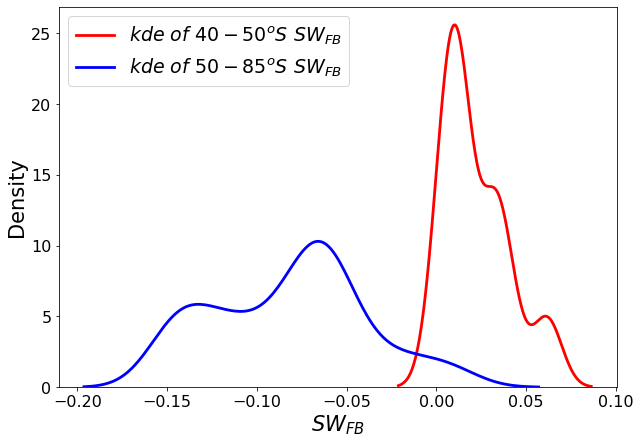

In [31]:
import seaborn as sns
# plot settings:
parameters = {'axes.labelsize': 21, 'legend.fontsize': 19,
       'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}
plt.rcParams.update(parameters)

plt.figure(figsize = (10, 7))

sns.kdeplot((SW_FB_4050[con_list_4050] * ratio_4050), common_norm = True, bw_adjust = 0.7, linewidth = 2.8, c='red', label = r"$ kde\ of\ 40-50^{o}S\ SW_{FB} $")

sns.kdeplot((SW_FB_5085[con_list_5085] * ratio_5085), common_norm = True, bw_adjust = 0.7, linewidth = 2.8, c='blue', label = r"$ kde\ of\ 50-85^{o}S\ SW_{FB} $")

plt.legend()
plt.xlabel(r"$SW_{FB}$")
plt.savefig(path_plot + "Fig_kde_of_LatitudeBandsCostraint.jpg")

(array([ 5,  7,  6, 10, 12,  2,  1,  3,  1,  2,  1]), array([-0.27707968, -0.22707968, -0.17707968, -0.12707968, -0.07707968,
       -0.02707968,  0.02292032,  0.07292032,  0.12292032,  0.17292032,
        0.22292032,  0.27292032]))


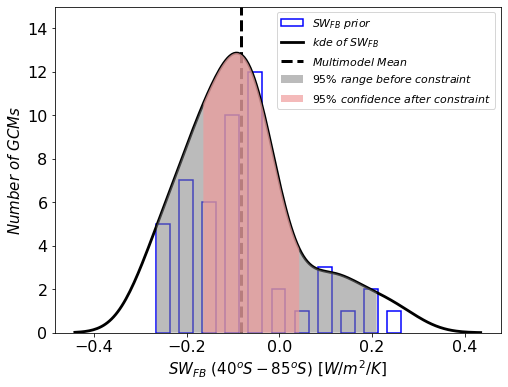

In [32]:
# kde + histogram plot: 
import seaborn as sns
parameters = {'axes.labelsize': 18, 'legend.fontsize': 14, 
         'axes.titlesize': 22,  'xtick.labelsize': 16,  'ytick.labelsize': 16}
plt.rcParams.update(parameters)

fig = plt.figure( figsize = (16.0/2., 12.0/2.))
ax = fig.add_subplot(111)

# Histogram:
# bins:

xinc = 0.05
xbins = np.arange( np.min(SW_FB_4085 * ratio_4085), np.max(SW_FB_4085 * ratio_4085)+xinc, xinc )
# print(xbins)
his_SW_FB = np.histogram((SW_FB_4085 * ratio_4085), xbins)
print(his_SW_FB)
xvals = his_SW_FB[1][:-1]
ax.bar(xvals + xinc/2, his_SW_FB[0] / 3.7, edgecolor = 'b', color = [], width = .03, label = r'$ SW_{FB}\ prior $', linewidth = 1.5)  # y-axis Scaled by 4. for visulization.

# # pdf continues line:
# fvalsx = his_SW_FB[0].astype(float)/(np.size(SW_FB_4085 ) * xinc)
# plt.plot(xvals + xinc/2, fvalsx, 'b', label = 'pdf', linewidth = 1.5)


# Kernel density estimate (seaborn kdeplot function use a Gaussian kernel):

kde_plot = sns.kdeplot((SW_FB_4085 * ratio_4085), common_norm = True, bw_adjust = 0.95, linewidth = 2.8, c = 'k', label = r'$ kde\ of\ SW_{FB}$')

# get the kernel distribution curve line for later fill:
kde_x, kde_y = kde_plot.lines[0].get_data()

ax.axvline(Mean_weighted_SWfb_SO, c = 'k', linewidth = 3., linestyle = '--', label = r'$ Multimodel\ Mean$', zorder = 97)

ax.fill_between(kde_x, kde_y, where=(kde_x > np.min(range_SWfb_SO_before)) & (kde_x < np.max(range_SWfb_SO_before)) , 
                interpolate= False, facecolor = 'gray', alpha = 0.53, label = r'$ 95 \%\ range\ before\ constraint $', zorder = 98)
ax.fill_between(kde_x, kde_y, where=(kde_x > np.min(range_SWfb_SO_after)) & (kde_x < np.max(range_SWfb_SO_after)) , 
                interpolate= False, facecolor = '#EF9A9A', alpha = 0.68, label = r'$ 95 \%\ confidence\ after\ constraint $', zorder = 99)

ax.set_ylim(0, 15/3.7)
ax.set_yticks(np.arange(0, 15/3.7, 2./3.7))
ax.set_yticklabels(np.arange(0, 15, 2))

ax.set_xlabel(r"$ SW_{FB}\ (40^{o} S - 85^{o} S)\ [W/ m^{2}/ K] $", fontsize = 15)
ax.set_ylabel(r"$ Number\ of\ GCMs $", fontsize = 15)

# change the order of legend:

# get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# specify order of items in legend
order = [4, 0, 1, 2, 3]

# add legend to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize = 11)
# plt.legend(fontsize = 11)

# plt.savefig(path_plot+ "Fig_9.jpg", bbox_inches = "tight", dpi = 500)